In [1]:
from MakeSens import MakeSens
import matplotlib.pyplot as plt
import pandas as pd
from service import cutdata 

import folium
import numpy as np
from scipy.signal import medfilt

from service import  load_racimo_data
from service import load_amb_data
from service import linear_calibration_model
from service import random_forest_calibration

In [2]:
EVA3 = MakeSens.download_data('E2_00003','2021-10-14 00:00:00', '2023-05-08 00:00:00','h', fields='pm10_1,pm10_2,pm25_1,pm25_2,temperatura,humedad,presion,irradiancia')
lasFerias = pd.read_csv('Data/RMCAB_Station_las_ferias_(2021-10_2023-5).csv')

In [3]:
EVA3.index = pd.DatetimeIndex(EVA3.index) -  pd.Timedelta(hours = 5, minutes = 0)
lasFerias.index =pd.DatetimeIndex(list(lasFerias.ts)) - pd.Timedelta(hours = 2, minutes = 0)

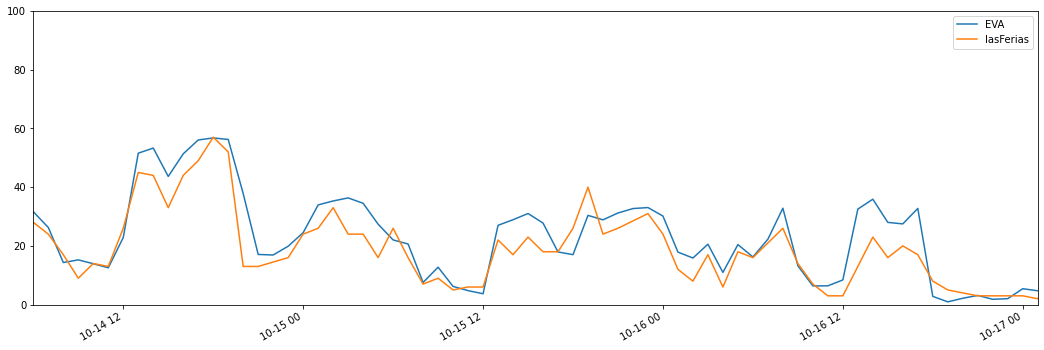

In [4]:
plt.figure(figsize=(18,6))
EVA3.pm25_1.plot(label = 'EVA')
lasFerias['pm2.5'].plot(label = 'lasFerias')
plt.ylim(0,100)
plt.xlim('2021-10-14 06:00:00','2021-10-17 01:00:00')
plt.legend()
plt.show()

De la gráfica anterior podemos identificar claramente que los periodos donde hay concordancia en los datos van desde 2022-09-01 hasta 2023-05-01 (fecha en donde se realiza este análisis). Por tanto los cuatro meses de datos que se toman para el análisis corresponden al rango 2023-10-01 al 2023-02-01.

In [5]:
EVA3 = cutdata(EVA3,'2021-10-14','2022-02-14')
lasFerias = cutdata(lasFerias, '2021-10-14','2022-02-14')
lasFerias = lasFerias[['pm10','pm2.5']]
EVA3 = EVA3[['pm10_1','pm25_1','temperatura','humedad','presion','irradiancia']]

EVA3 = EVA3.loc[~EVA3.index.duplicated(keep='first')]
lasFerias = lasFerias.loc[~lasFerias.index.duplicated(keep='first')]

In [6]:
# Suavisar los datos usando un filtro de mediana a las columnas de particulado
for column in EVA3.columns:
    EVA3[column] = medfilt(EVA3[column],21)

for column in lasFerias.columns:
    lasFerias[column] = medfilt(lasFerias[column],21)

# Unir las dos datas en una sola y dejar solo donde hay datos en las dos
data = pd.concat([lasFerias,EVA3],axis = 1).dropna()

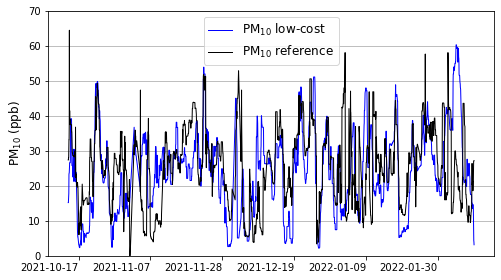

In [7]:
plt.figure(figsize = (8,5))
data.pm10_1.plot(label='PM$_{10}$ low-cost',lw=1,c='b')
data.pm10.plot(label='PM$_{10}$ reference',lw=1,c='k')
plt.legend(fontsize = 12)
plt.ylabel("PM$_{10}$ (ppb)", fontsize = 12)
plt.grid(axis='y')
plt.ylim(0,70)
plt.xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='3W'),rotation=0)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.savefig("pm10_E2_00003_var.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

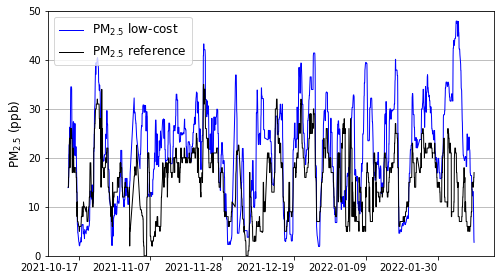

In [8]:
plt.figure(figsize=(8,5))
data['pm25_1'].plot(label='PM$_{2.5}$ low-cost',lw=1,c='b')
data["pm2.5"].plot(label='PM$_{2.5}$ reference',lw=1,c='k')
plt.legend(fontsize = 12)
plt.ylabel("PM$_{2.5}$ (ppb)", fontsize = 12)
plt.grid(axis='y')
plt.ylim(0,50)
plt.xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='3W'),rotation=0)
plt.savefig("pm25_E2_00003_var.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

### Linear calibration model

In [9]:
# PM10
LR_pm10 = linear_calibration_model(data['pm10_1'],data['pm10'] )
# PM2.5
LR_pm25 = linear_calibration_model(data['pm25_1'],data['pm2.5'])

In [10]:
print('Linear model - PM10')
LR_pm10

Linear model - PM10


{'RMSE': 9.642855931958595,
 'COEF': array([0.3884767]),
 'Intercept': 16.40935963963387,
 'r2_score': -3.573693822452509,
 'correlation': 0.4199148658691925,
 'NRMSE': 0.20269170475074957}

In [11]:
print('Linear model - PM25')
LR_pm25

Linear model - PM25


{'RMSE': 5.844618920302287,
 'COEF': array([0.36420926]),
 'Intercept': 7.405362416982938,
 'r2_score': -1.667572505525532,
 'correlation': 0.5236259298489211,
 'NRMSE': 0.21610717217664435}

# Multilineal

In [12]:
MLR_pm10 = linear_calibration_model(data[['pm10_1','temperatura','presion','humedad','irradiancia']],data['pm10'])
MLR_pm25 = linear_calibration_model(data[['pm25_1','temperatura','presion','humedad','irradiancia']],data['pm2.5'])

In [13]:
print('Multilinear model - PM10')
MLR_pm10

Multilinear model - PM10


{'RMSE': 9.62747893248253,
 'COEF': array([ 0.31959525, -0.140585  , -2.21334356,  0.23675364,  0.01440387]),
 'Intercept': 1668.9070771915285,
 'r2_score': -2.82268101781743,
 'correlation': 0.43951459289842726,
 'NRMSE': 0.20089510986691037}

In [14]:
print('Multilinear model - PM2.5')
MLR_pm25

Multilinear model - PM2.5


{'RMSE': 5.823686906510619,
 'COEF': array([ 0.31016813,  0.15346625, -0.5728931 ,  0.1785637 ,  0.00399256]),
 'Intercept': 425.20211393126897,
 'r2_score': -1.3953243674227185,
 'correlation': 0.5372054950445818,
 'NRMSE': 0.2160496909037305}

### Ramdom forest

In [15]:
# PM10
pm10_rf, RF_pm10 = random_forest_calibration(data[['pm10_1','temperatura','presion','humedad','irradiancia']],data['pm10'])
# PM2.5
pm25_rf, RF_pm25 = random_forest_calibration(data[['pm25_1','temperatura','presion','humedad','irradiancia']],data['pm2.5'])

mse [0.40227862 0.18908626 0.1623313  0.1684789  0.07782492] <bound method BaseEstimator.get_params of RandomForestRegressor(n_estimators=800, random_state=673)> 5
mse [0.49315865 0.13790764 0.12179902 0.14984333 0.09729137] <bound method BaseEstimator.get_params of RandomForestRegressor(n_estimators=800, random_state=329)> 5


In [16]:
print('RF - PM10')
RF_pm10

RF - PM10


{'RMSE': 5.279487441896553,
 'r2_score': 0.6254117994149058,
 'correlation': 0.8826267943786065,
 'NRMSE': 0.1271927305812081,
 'accuracy': 79.0161182944158}

In [17]:
print('RF - PM2.5')
RF_pm25

RF - PM2.5


{'RMSE': 3.196718701224466,
 'r2_score': 0.6835895935006494,
 'correlation': 0.8951706357631521,
 'NRMSE': 0.1434372022682634,
 'accuracy': 80.84018213227401}

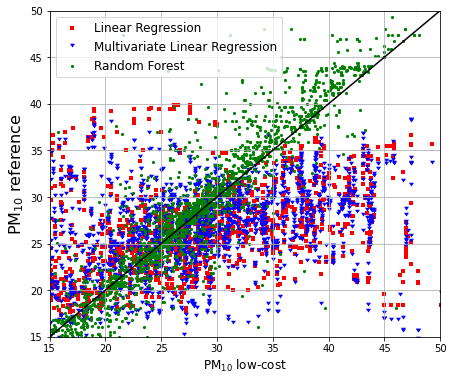

In [18]:
plt.figure(figsize=(7,6))

plt.scatter(data["pm10"],data["pm10_1"]*LR_pm10['COEF'][0] + LR_pm10['Intercept'], label='Linear Regression',lw=0.01,marker='s',alpha=1,c='r',s=10)
plt.scatter(data["pm10"],data["pm10_1"]*MLR_pm10['COEF'][0]+
            data["temperatura"]*MLR_pm10['COEF'][1]+
            data["presion"]*MLR_pm10['COEF'][2]+
            data["humedad"]*MLR_pm10['COEF'][3]+
            MLR_pm10['Intercept'],label='Multivariate Linear Regression',lw=0.01,marker=7,alpha=1,c='b',s=25)
plt.scatter(pm10_rf,data["pm10"],label='Random Forest',lw=0.01,marker='o',alpha=1,c='g',s=10) 
x=np.linspace(15,100,10)
plt.plot(x,x,'k-')
plt.ylabel("PM$_{10}$ reference", fontsize = 16)
plt.xlabel("PM$_{10}$ low-cost", fontsize = 12)
plt.ylim(15,50)
plt.xlim(15,50)
plt.grid()
plt.legend(fontsize = 12)
plt.savefig("pm10_bga_method.pdf",bbox_inches='tight',pad_inches=0)
plt.show()

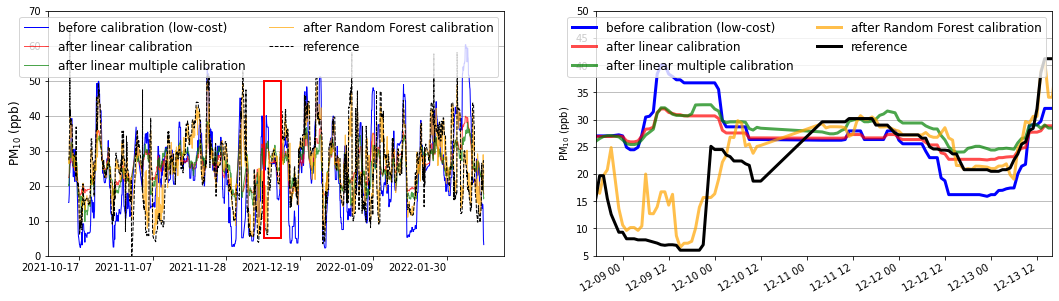

In [19]:
import matplotlib.patches as patches

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))

# subplot 1
data["pm10_1"].plot(label="before calibration (low-cost)", lw=1, c='b', ax=ax1)

ax1.plot(data.index,data["pm10_1"]*LR_pm10['COEF'][0] + LR_pm10['Intercept'],
         label='after linear calibration',lw=1,c='r',linestyle='-',alpha=0.7)
ax1.plot(data.index,data["pm10_1"]*MLR_pm10['COEF'][0]+
            data["temperatura"]*MLR_pm10['COEF'][1]+
            data["presion"]*MLR_pm10['COEF'][2]+
            data["humedad"]*MLR_pm10['COEF'][3]+
            MLR_pm10['Intercept'],label='after linear multiple calibration',lw=1,c='g',linestyle='-',alpha=0.7)
ax1.plot(data.index,pm10_rf,label='after Random Forest calibration',lw=1,c='orange',linestyle='-',alpha=0.7)
data["pm10"].plot(label="reference", lw=1, c='k', linestyle='--', ax=ax1)
ax1.plot([data.index[1124] , data.index[1224] ], [5, 5], color='r',linewidth=2)
ax1.plot([data.index[1124] ,  data.index[1124]], [5, 50], color='r', linewidth=2)
ax1.plot([data.index[1123] , data.index[1224] ], [50, 50], color='r',linewidth=2)
ax1.plot([data.index[1224] ,data.index[1224] ], [50, 5], color='r', linewidth=2)

ax1.set_ylim(0, 70)
ax1.legend(ncol=2, fontsize =12)
ax1.set_ylabel("PM$_{10}$ (ppb)", fontsize= 12)
ax1.grid(axis='y')
ax1.set_xticks(pd.date_range(start=data.index.min(), end=data.index.max(), freq='3W'))
ax1.tick_params(axis='x', rotation=0)

# subplot 2
data["pm10_1"].plot(label="before calibration (low-cost)", lw=3, c='b', ax=ax2)

ax2.plot(data.index,data["pm10_1"]*LR_pm10['COEF'][0] + LR_pm10['Intercept'],
         label='after linear calibration',lw=3,c='r',alpha=0.7)
ax2.plot(data.index,data["pm10_1"]*MLR_pm10['COEF'][0]+
            data["temperatura"]*MLR_pm10['COEF'][1]+
            data["presion"]*MLR_pm10['COEF'][2]+
            data["humedad"]*MLR_pm10['COEF'][3]+
            MLR_pm10['Intercept'],label='after linear multiple calibration',lw=3,c='g',linestyle='-',alpha=0.7)
ax2.plot(data.index,pm10_rf,label='after Random Forest calibration',lw=3,c='orange',linestyle='-',alpha=0.7)
data["pm10"].plot(label="reference", lw=3, c='k', linestyle='-', ax=ax2)
ax2.set_ylim(5, 50)
ax2.set_xlim('2021-12-08 17:00:00','2021-12-13 16:00:00')
ax2.legend(ncol=2, fontsize = 12)
ax2.set_ylabel("PM$_{10}$ (ppb)")
ax2.grid(axis='y')

plt.savefig("pm10_bga_allcalib.pdf",bbox_inches='tight',pad_inches=0)


In [20]:
data.index[1224]

Timestamp('2021-12-13 16:00:00')